In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


---
**Chapter 1: Data Preprocessing**
---


`1.1.` Clean the dataset by handling:
*   Missing values
*   Encoding categorical features with label encoding
*   Standardizing numerical features


In [ ]:
import pandas as pd
import numpy as np
import re
from sklearn.preprocessing import LabelEncoder, StandardScaler
import seaborn as sns

# Load the dataset
file_path = '/content/drive/MyDrive/Machine/Assignment2/cars.csv'
cars_df = pd.read_csv(file_path)

# Step 1: Convert non-numeric values in 'cylinder', 'horse_power', 'top_speed', and 'seats' to NaN where necessary
cars_df['cylinder'] = pd.to_numeric(cars_df['cylinder'], errors='coerce')
cars_df['horse_power'] = pd.to_numeric(cars_df['horse_power'], errors='coerce')
cars_df['top_speed'] = pd.to_numeric(cars_df['top_speed'], errors='coerce')

# Step 2: Clean the 'seats' column
cars_df['seats'] = cars_df['seats'].replace(['N A', 'Automatic', 'Seating Capacity'], np.nan)  # replace non-relevant text
cars_df['seats'] = cars_df['seats'].str.extract('(\d+)').astype(float)  # extract numeric part
cars_df['seats'] = cars_df['seats'].astype('Int64')  # convert to integer type

# Step 3: Filter out unlikely seat counts (e.g., greater than 9) and replace them with NaN
cars_df.loc[cars_df['seats'] > 9, 'seats'] = np.nan

# Step 4: Fill missing values in 'cylinder', 'horse_power', 'top_speed' , 'seats' with mode
cylinder_mode = cars_df['cylinder'].mode()[0]
cars_df['cylinder'] = cars_df['cylinder'].fillna(cylinder_mode)

horse_power_mode = cars_df['horse_power'].mode()[0]
cars_df['horse_power'] = cars_df['horse_power'].fillna(horse_power_mode)

top_speed_mode = cars_df['top_speed'].mode()[0]
cars_df['top_speed'] = cars_df['top_speed'].fillna(top_speed_mode)

seats_mode = cars_df['seats'].mode()[0]
cars_df['seats'] = cars_df['seats'].fillna(seats_mode)

# Step 5: Clean the 'price' column
# Define exchange rates (example values; replace with actual rates)
exchange_rates = {
    "SAR": 0.27,  # Saudi Riyal to USD
    "EGP": 0.032, # Egyptian Pound to USD
    "BHD": 2.65,  # Bahraini Dinar to USD
    "QAR": 0.27,  # Qatari Riyal to USD
    "OMR": 2.60,  # Omani Rial to USD
    "KWD": 3.26   # Kuwaiti Dinar to USD
}

# Function to extract currency and price
def extract_price(value):
    if isinstance(value, str):
        # Search for currency and price
        match = re.search(r"([A-Z]+)\s*([\d,]+(\.\d{1,2})?)", value)
        if match:
            currency, price = match.group(1), match.group(2)
            price = float(price.replace(",", ""))
            return currency, price
    return np.nan, np.nan

# Apply extraction function
cars_df[['currency', 'price_numeric']] = cars_df['price'].apply(lambda x: pd.Series(extract_price(x)))

# Step 6: Convert all prices to USD
def convert_to_usd(row):
    currency = row['currency']
    price = row['price_numeric']
    if pd.notna(currency) and pd.notna(price):
        return price * exchange_rates.get(currency, np.nan)
    return np.nan

cars_df['price_usd'] = cars_df.apply(convert_to_usd, axis=1)

# Step 7: Encode categorical features using label encoding
label_encoder_brand = LabelEncoder()
label_encoder_country = LabelEncoder()
cars_df['brand_encoded'] = label_encoder_brand.fit_transform(cars_df['brand'])
cars_df['country_encoded'] = label_encoder_country.fit_transform(cars_df['country'])

# Remove the original 'brand' and 'country' columns
cars_df.drop(columns=['brand', 'country'], inplace=True)

# Step 8: Replace non-converted price with NaN and then fill them with median
price_usd_median = cars_df['price_usd'].median()
cars_df['price_usd'] = cars_df['price_usd'].fillna(price_usd_median)

# Step 10: Remove the original 'price' and intermediate columns, and rename 'price_usd' to 'price'
cars_df = cars_df.drop(columns=['price', 'currency', 'price_numeric'])
cars_df = cars_df.rename(columns={'price_usd': 'price'})

# Standardize numerical columns except 'car name'
scaler = StandardScaler()
numeric_columns = ['engine_capacity', 'cylinder', 'horse_power', 'top_speed', 'seats', 'price', 'brand_encoded', 'country_encoded']
# Check and convert all specified columns to numeric, handling NaNs
for column in numeric_columns:
    cars_df[column] = pd.to_numeric(cars_df[column], errors='coerce')
    cars_df[column] = cars_df[column].fillna(cars_df[column].mean())
cars_df[numeric_columns] = scaler.fit_transform(cars_df[numeric_columns])

# Save the final modified dataset to a new file
new_file_path = '/content/drive/MyDrive/Machine/Assignment2/cars_fully_cleaned_standardized.csv'
cars_df.to_csv(new_file_path, index=False)

print(f"Cleaned data saved to: {new_file_path}")

Cleaned data saved to: /content/drive/MyDrive/Machine/Assignment2/cars_fully_cleaned_standardized.csv


**`1.2.`** Checking standard deviations to verify the accuracy of the standardization process.

In [ ]:
import pandas as pd

# Load the dataset
file_path = '/content/drive/MyDrive/Machine/Assignment2/cars_fully_cleaned_standardized.csv'
cars_data = pd.read_csv(file_path)

# Calculate the mean for each column, excluding non-numeric data
mean_values = cars_data.mean(numeric_only=True)

# Calculate the standard deviation for each column, excluding non-numeric data
standard_deviations = cars_data.std(numeric_only=True)

# Display the results
print("Means of each column:")
print(mean_values)
print("\nStandard Deviations of each column:")
print(standard_deviations)

# Verify remaining columns
print("Remaining columns:\n", cars_df.columns)



Means of each column:
engine_capacity    1.802264e-17
cylinder          -2.703397e-17
horse_power       -9.011322e-17
top_speed         -1.531925e-16
seats             -1.667095e-16
price              7.772265e-17
brand_encoded      3.604529e-17
country_encoded    0.000000e+00
dtype: float64

Standard Deviations of each column:
engine_capacity    1.000079
cylinder           1.000079
horse_power        1.000079
top_speed          1.000079
seats              1.000079
price              1.000079
brand_encoded      1.000079
country_encoded    1.000079
dtype: float64
Remaining columns:
 Index(['car name', 'engine_capacity', 'cylinder', 'horse_power', 'top_speed',
       'seats', 'price', 'brand_encoded', 'country_encoded'],
      dtype='object')


`1.3.` split the dataset into three parts: 60% for training, 20% for validation, and 20% for testing.





In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the dataset
file_path = '/content/drive/MyDrive/Machine/Assignment2/cars_fully_cleaned_standardized.csv'
cars_data = pd.read_csv(file_path)

# Splitting the dataset into training (60%), validation (20%), and testing (20%) sets
# First, split into training (60%) and temp_data (40%)
train_data, temp_data = train_test_split(cars_data, test_size=0.4, random_state=42)

# Now split temp_data into validation and test sets (each 20% of the original data)
validation_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

# Save the datasets to CSV files
train_data.to_csv('/content/drive/MyDrive/Machine/Assignment2/train_data.csv', index=False)
validation_data.to_csv('/content/drive/MyDrive/Machine/Assignment2/validation_data.csv', index=False)
test_data.to_csv('/content/drive/MyDrive/Machine/Assignment2/test_data.csv', index=False)

print("Data has been split and saved to files.")

Data has been split and saved to files.


---
**Chapter 2: Building Regression Models**
---

`2.1.` Linear Regression Models
*  Trains and evaluates a standard linear regression model.
*   Implements LASSO and Ridge regression to address overfitting
*   Uses Grid Search for α optimization, a critical part of finding the best-fit model.








In [ ]:
import warnings
from sklearn.exceptions import ConvergenceWarning

# Ignore ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import make_pipeline

# Load the datasets
train_data = pd.read_csv('/content/drive/MyDrive/Machine/Assignment2/train_data.csv')
validation_data = pd.read_csv('/content/drive/MyDrive/Machine/Assignment2/validation_data.csv')

# Assuming 'price' is the target variable
y_train = train_data['price']
y_val = validation_data['price']

# Prepare the features, removing the target column and any non-numeric columns that cause errors
X_train = pd.get_dummies(train_data.drop('price', axis=1))
X_val = pd.get_dummies(validation_data.drop('price', axis=1))

# Ensure both datasets have the same dummy variables
X_train, X_val = X_train.align(X_val, join='inner', axis=1)

def evaluate_model(model, X_train, y_train, X_val, y_val, model_name):
    model.fit(X_train, y_train)
    predictions = model.predict(X_val)
    mse = mean_squared_error(y_val, predictions)
    mae = mean_absolute_error(y_val, predictions)
    r2 = r2_score(y_val, predictions)
    print(f"{model_name} - MSE: {mse:.2f}, MAE: {mae:.2f}, R^2: {r2:.3f}")

# Evaluating Linear, LASSO, and Ridge Models
evaluate_model(LinearRegression(), X_train, y_train, X_val, y_val, "Linear Regression")

# Grid Search for LASSO and Ridge
parameters = {'alpha': np.logspace(-6, 2, 9)}
lasso_grid = GridSearchCV(Lasso(), parameters, cv=5, scoring='neg_mean_squared_error')
ridge_grid = GridSearchCV(Ridge(), parameters, cv=5, scoring='neg_mean_squared_error')

evaluate_model(lasso_grid, X_train, y_train, X_val, y_val, "LASSO Regression with Grid Search")
print("Best alpha for LASSO:", lasso_grid.best_params_)

evaluate_model(ridge_grid, X_train, y_train, X_val, y_val, "Ridge Regression with Grid Search")
print("Best alpha for Ridge:", ridge_grid.best_params_)


Linear Regression - MSE: 0.20, MAE: 0.22, R^2: 0.568
LASSO Regression with Grid Search - MSE: 0.18, MAE: 0.23, R^2: 0.611
Best alpha for LASSO: {'alpha': 0.0001}
Ridge Regression with Grid Search - MSE: 0.19, MAE: 0.22, R^2: 0.593
Best alpha for Ridge: {'alpha': 0.1}


`2.2.` Closed-Form and Gradient Descent Solutions
*   Encodes categorical features, aligns datasets, and imputes missing values.

*   Directly calculates Closed-Form model parameters using the normal equation.

*   In Gradient Descent,Iteratively optimizes parameters with adjustable learning rate and convergence steps.

*   Assesses both methods using MSE, MAE, and R^2 on the validation set.


In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def closed_form_solution(X, y):
    """ Calculate the closed-form solution for linear regression """
    X_b = np.hstack([np.ones((X.shape[0], 1)), X])  # Adding a column of ones for the intercept term
    theta_best = np.linalg.pinv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)
    return theta_best

def gradient_descent(X, y, lr=0.01, iterations=1000):
    m = len(y)
    X_b = np.hstack([np.ones((X.shape[0], 1)), X])  # Add intercept term
    theta = np.random.randn(X_b.shape[1], 1)
    for iteration in range(iterations):
        predictions = X_b.dot(theta)
        errors = predictions - y
        gradients = 2/m * X_b.T.dot(errors)
        theta -= lr * gradients
        if iteration % 100 == 0:
            cost = (errors**2).mean()
            print(f"Iteration {iteration}, Cost: {cost}")
    return theta

def calculate_metrics(X, y, model, description):
    X_b = np.hstack([np.ones((X.shape[0], 1)), X])  # Add intercept term
    predictions = X_b.dot(model)
    mse = mean_squared_error(y, predictions)
    mae = mean_absolute_error(y, predictions)
    r2 = r2_score(y, predictions)
    print(f"{description} - MSE: {mse:.2f}, MAE: {mae:.2f}, R^2: {r2:.3f}")

# Load and prepare the dataset
train_data = pd.read_csv('/content/drive/MyDrive/Machine/Assignment2/train_data.csv')
validation_data = pd.read_csv('/content/drive/MyDrive/Machine/Assignment2/validation_data.csv')

# Create dummy variables and ensure both datasets have the same columns
X_train_df = pd.get_dummies(train_data.drop(['price'], axis=1))
X_val_df = pd.get_dummies(validation_data.drop(['price'], axis=1))

# Align the feature sets
X_train_df, X_val_df = X_train_df.align(X_val_df, join='inner', axis=1)  # Align the features

# Explicitly convert all columns to numeric, replacing errors with NaN
X_train_df = X_train_df.apply(pd.to_numeric, errors='coerce')
X_val_df = X_val_df.apply(pd.to_numeric, errors='coerce')

# Impute NaN values with 0 (or another strategy like mean/median)
X_train_df = X_train_df.fillna(0)
X_val_df = X_val_df.fillna(0)

# Convert to NumPy arrays
X_train = X_train_df.values.astype(np.float64)  # Ensure float64 dtype
X_val = X_val_df.values.astype(np.float64)  # Ensure float64 dtype

# Ensure y_train and y_val are also float64 and have the correct shape
y_train = train_data['price'].values.astype(np.float64).reshape(-1, 1)
y_val = validation_data['price'].values.astype(np.float64).reshape(-1, 1)

# Calculate closed-form solution
theta_cf = closed_form_solution(X_train, y_train)
calculate_metrics(X_val, y_val, theta_cf, "Closed-Form Solution on Validation Set")

# Calculate gradient descent solution
theta_gd = gradient_descent(X_train, y_train)
calculate_metrics(X_val, y_val, theta_gd, "Gradient Descent Solution on Validation Set")


Closed-Form Solution on Validation Set - MSE: 0.20, MAE: 0.22, R^2: 0.568
Iteration 0, Cost: 5.70562664105821
Iteration 100, Cost: 1.2050730990827028
Iteration 200, Cost: 1.1293396799001352
Iteration 300, Cost: 1.1227792056271837
Iteration 400, Cost: 1.1206220575287862
Iteration 500, Cost: 1.1190677481113998
Iteration 600, Cost: 1.117621767824456
Iteration 700, Cost: 1.1162003718705105
Iteration 800, Cost: 1.1147877739904197
Iteration 900, Cost: 1.1133808037790724
Gradient Descent Solution on Validation Set - MSE: 0.85, MAE: 0.65, R^2: -0.867


`2.3. `Polynomial and RBF Kernel Regression
*   Encodes categorical features, aligns datasets, and removes low-variance columns.

*   Handles missing values by imputing them and ensures data consistency for modeling.

*   Polynomial Regression: Evaluates polynomial models for degrees 2 to 10 to capture nonlinear relationships.

*   RBF Kernel Regression: Applies Radial Basis Function (RBF) Kernel Ridge Regression for non-linear mapping.

*   Assesses both methods using MSE, MAE, and R^2 on the validation set.

    Degree  Alpha  Train MSE  Train MAE  Train R²  Validation MSE  \
0        2      1   0.490627   0.315944  0.537724        0.304200   
1        2     10   0.491063   0.312021  0.537313        0.297314   
2        2    100   0.506475   0.292680  0.522792        0.267302   
3        2   1000   0.579687   0.266826  0.453811        0.250322   
4        3      1   0.219502   0.243067  0.793182        0.219716   
5        3     10   0.224485   0.241663  0.788487        0.222246   
6        3    100   0.243755   0.233988  0.770330        0.225670   
7        3   1000   0.336217   0.234332  0.683211        0.235262   
8        4      1   0.121003   0.181887  0.885990        0.198756   
9        4     10   0.135053   0.187910  0.872751        0.170062   
10       4    100   0.166251   0.190835  0.843356        0.177672   
11       4   1000   0.236973   0.212544  0.776721        0.209202   
12       5      1   0.092611   0.154677  0.912741        0.177433   
13       5     10   0.103132   0.1

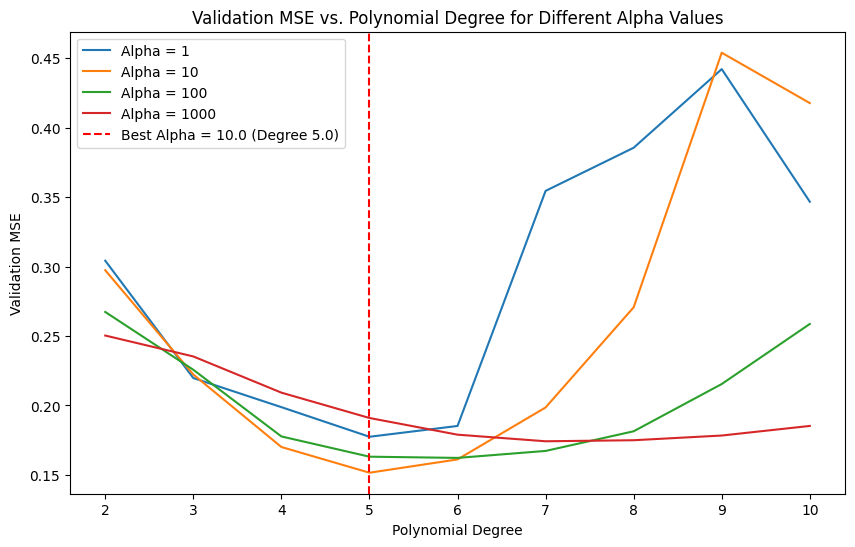

In [ ]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load datasets
train_data = pd.read_csv('/content/drive/MyDrive/Machine/Assignment2/train_data.csv')
validation_data = pd.read_csv('/content/drive/MyDrive/Machine/Assignment2/validation_data.csv')

# Preprocessing: Drop unnecessary columns and align datasets
X_train = train_data.drop(['price', 'car name'], axis=1)
y_train = train_data['price']
X_val = validation_data.drop(['price', 'car name'], axis=1)
y_val = validation_data['price']

# Align features across datasets
X_train, X_val = X_train.align(X_val, join='inner', axis=1, fill_value=0)

# Initialize a list to store results
results_list = []

# Iterate over polynomial degrees and Ridge alphas
for degree in range(2, 11):  # Degrees 2 to 10
    for alpha in [1, 10, 100, 1000]:
        pipeline = make_pipeline(PolynomialFeatures(degree), StandardScaler(), Ridge(alpha=alpha))

        # Fit on training data
        pipeline.fit(X_train, y_train)

        # Predict on training and validation sets
        y_train_pred = pipeline.predict(X_train)
        y_val_pred = pipeline.predict(X_val)

        # Calculate metrics
        train_mse = mean_squared_error(y_train, y_train_pred)
        train_mae = mean_absolute_error(y_train, y_train_pred)
        train_r2 = r2_score(y_train, y_train_pred)

        val_mse = mean_squared_error(y_val, y_val_pred)
        val_mae = mean_absolute_error(y_val, y_val_pred)
        val_r2 = r2_score(y_val, y_val_pred)

        # Store results
        results_list.append({
            'Degree': degree,
            'Alpha': alpha,
            'Train MSE': train_mse,
            'Train MAE': train_mae,
            'Train R²': train_r2,
            'Validation MSE': val_mse,
            'Validation MAE': val_mae,
            'Validation R²': val_r2
        })

# Create a DataFrame from the results
results = pd.DataFrame(results_list)

# Print all results
print(results)

# Find the best model based on Validation MSE
best_model_info = results.loc[results['Validation MSE'].idxmin()]
best_degree = best_model_info['Degree']
best_alpha = best_model_info['Alpha']

print("\nBest Model Configuration from Validation:")
print(f"Degree: {best_degree}, Alpha: {best_alpha}")

# Plot Validation MSE for each alpha value
plt.figure(figsize=(10, 6))
for alpha in [1, 10, 100, 1000]:
    subset = results[results['Alpha'] == alpha]
    plt.plot(subset['Degree'], subset['Validation MSE'], label=f'Alpha = {alpha}')

# Highlight the best alpha and degree
plt.axvline(x=best_degree, color='red', linestyle='--', label=f'Best Alpha = {best_alpha} (Degree {best_degree})')

plt.xlabel("Polynomial Degree")
plt.ylabel("Validation MSE")
plt.title("Validation MSE vs. Polynomial Degree for Different Alpha Values")
plt.legend()
plt.show()


---
**Chapter 3:  Forward Selection**
---

`3.1. ` Polynomial Regression (degree 6)  model with Forward Selection

*   Start with an empty model and gradually add features one at a time.
*   For each feature, it trains a **Polynomial Regression (degree 6) ** using the selected features and calculates the MSE on the validation set.

*   At each step, add the feature that, when included, minimizes the error on the
validation set.
*   Stop once additional features no longer improve the model performance or a
maximum number of features is reached.

Added feature 'horse_power', MSE: 0.33
Added feature 'top_speed', MSE: 0.23
Added feature 'brand_encoded', MSE: 0.19
Added feature 'cylinder', MSE: 0.15
Added feature 'country_encoded', MSE: 0.14
Added feature 'seats', MSE: 0.13

Selected feature indices: [2, 3, 5, 1, 6, 4]
Selected feature names: ['horse_power', 'top_speed', 'brand_encoded', 'cylinder', 'country_encoded', 'seats']





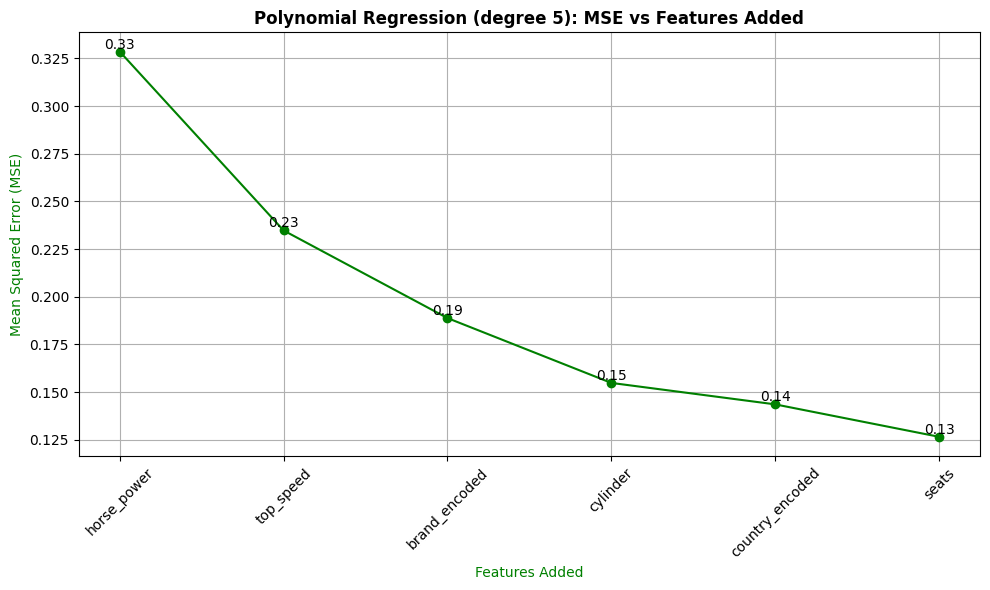

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
import warnings

# Suppress all warnings
warnings.simplefilter('ignore')

# Load datasets
train_data = pd.read_csv('/content/drive/MyDrive/Machine/Assignment2/train_data.csv')
validation_data = pd.read_csv('/content/drive/MyDrive/Machine/Assignment2/validation_data.csv')

# Drop non-numeric columns like 'car name'
train_data = train_data.drop(['car name'], axis=1)
validation_data = validation_data.drop(['car name'], axis=1)

# Define target variable and features
y_train = train_data['price'].values
y_val = validation_data['price'].values

# Drop the target column to prepare features
X_train_df = train_data.drop(['price'], axis=1)
X_val_df = validation_data.drop(['price'], axis=1)

# Align training and validation datasets to ensure consistent features
X_train_df, X_val_df = X_train_df.align(X_val_df, join='inner', axis=1)

# Convert to NumPy arrays for model fitting
X_train = X_train_df.values.astype(np.float64)
X_val = X_val_df.values.astype(np.float64)

# Forward Selection for Polynomial Regression (degree 6)
def forward_selection_poly(X_train, y_train, X_val, y_val, feature_names, degree=6):
    selected_features = []  # Indices of selected features
    remaining_features = list(range(X_train.shape[1]))  # Indices of all features
    best_mse = float('inf')  # Initialize best MSE to a large value

    mse_values = []  # To store MSE at each step
    feature_names_added = []  # To store feature names added at each step

    # Initialize PolynomialFeatures
    poly = PolynomialFeatures(degree=degree)

    while remaining_features:
        feature_to_add = None
        for feature in remaining_features:
            # Evaluate the feature by adding it to the selected features
            candidate_features = selected_features + [feature]
            X_poly_train = poly.fit_transform(X_train[:, candidate_features])
            X_poly_val = poly.transform(X_val[:, candidate_features])

            model = Ridge(alpha=100)
            model.fit(X_poly_train, y_train)
            predictions = model.predict(X_poly_val)
            mse = mean_squared_error(y_val, predictions)

            # Update the best feature if it improves the MSE
            if mse < best_mse:
                best_mse = mse
                feature_to_add = feature

        # Stop if no feature improves the model
        if feature_to_add is None:
            break

        # Add the best feature to the selected list
        selected_features.append(feature_to_add)
        remaining_features.remove(feature_to_add)
        mse_values.append(best_mse)
        feature_names_added.append(feature_names[feature_to_add])

        # Print the feature and its MSE value
        print(f"Added feature '{feature_names[feature_to_add]}', MSE: {best_mse:.2f}")

    return selected_features, mse_values, feature_names_added

# Perform forward selection for Polynomial Regression (degree 5)
feature_names = X_train_df.columns
selected_features, mse_values, feature_names_added = forward_selection_poly(
    X_train, y_train, X_val, y_val, feature_names, degree=5
)

# Print selected features and their names
print("\nSelected feature indices:", selected_features)
print("Selected feature names:", [feature_names[i] for i in selected_features])
print("\n\n")

# Plot MSE vs. Features Added for Polynomial Regression (degree 5)
selected_feature_names_to_plot = [feature_names[i] for i in selected_features]
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(mse_values) + 1), mse_values, marker='o', linestyle='-', color='g')
plt.xticks(range(1, len(mse_values) + 1), selected_feature_names_to_plot, rotation=45)
plt.xlabel('Features Added', color='g')
plt.ylabel('Mean Squared Error (MSE)', color='g')
plt.title('Polynomial Regression (degree 5): MSE vs Features Added', fontweight='bold', color='black')

# Annotate each point with the MSE value
for i, mse in enumerate(mse_values):
    plt.text(i+1, mse, f'{mse:.2f}', ha='center', va='bottom', color='black', fontsize=10)

plt.tight_layout()
plt.grid()
plt.show()


`3.2. ` RBF Kernel Ridge Regression model with Forward Selection

*   Start with an empty model and gradually add features one at a time.
*   For each feature, it trains a **RBF Kernel Ridge Regression** using the selected features and calculates the MSE on the validation set.

*   At each step, add the feature that, when included, minimizes the error on the
validation set.
*   Stop once additional features no longer improve the model performance or a
maximum number of features is reached.

Added feature 'horse_power', MSE: 0.26
Added feature 'seats', MSE: 0.23
Added feature 'top_speed', MSE: 0.21
Added feature 'brand_encoded', MSE: 0.19
Added feature 'cylinder', MSE: 0.18
Added feature 'country_encoded', MSE: 0.17
Selected feature indices: [2, 4, 3, 5, 1, 6]
Selected feature names: ['horse_power', 'seats', 'top_speed', 'brand_encoded', 'cylinder', 'country_encoded']


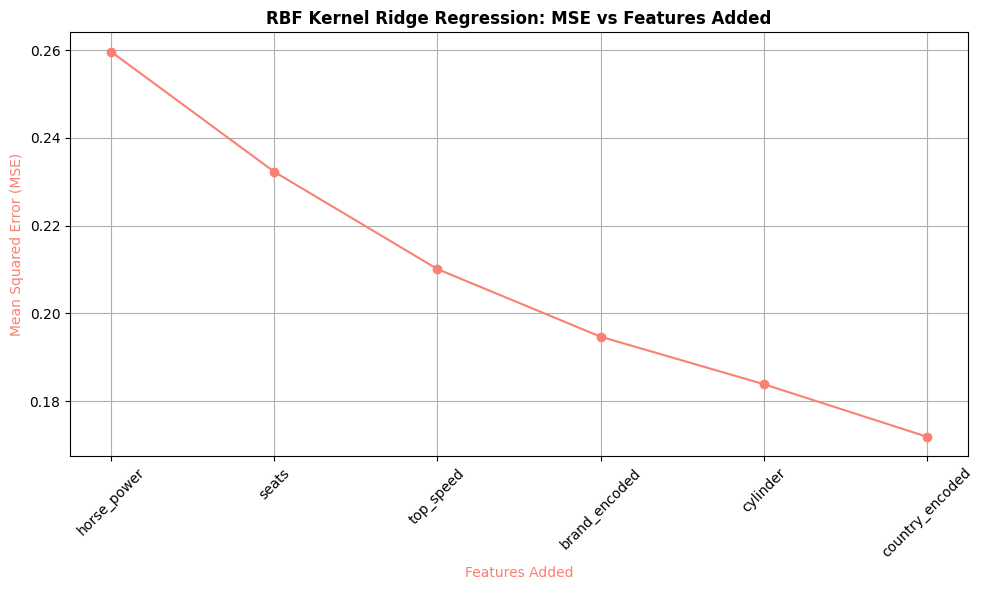

In [ ]:
import pandas as pd
import numpy as np
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Load datasets
train_data = pd.read_csv('/content/drive/MyDrive/Machine/Assignment2/train_data.csv')
validation_data = pd.read_csv('/content/drive/MyDrive/Machine/Assignment2/validation_data.csv')

# Drop non-numeric columns like 'car name'
train_data = train_data.drop(['car name'], axis=1)
validation_data = validation_data.drop(['car name'], axis=1)

# Define target variable and features
y_train = train_data['price'].values
y_val = validation_data['price'].values

# Drop the target column to prepare features
X_train_df = train_data.drop(['price'], axis=1)
X_val_df = validation_data.drop(['price'], axis=1)

# Align training and validation datasets to ensure consistent features
X_train_df, X_val_df = X_train_df.align(X_val_df, join='inner', axis=1)

# Convert to NumPy arrays for model fitting
X_train = X_train_df.values.astype(np.float64)
X_val = X_val_df.values.astype(np.float64)

# Forward Selection for RBF Kernel Ridge Regression
def forward_selection_rbf(X_train, y_train, X_val, y_val, feature_names):
    selected_features = []  # Indices of selected features
    remaining_features = list(range(X_train.shape[1]))  # Indices of all features
    best_mse = float('inf')  # Initialize best MSE to a large value

    mse_values = []  # To store MSE at each step
    feature_names_added = []  # To store feature names added at each step

    while remaining_features:
        feature_to_add = None
        for feature in remaining_features:
            # Evaluate the feature by adding it to the selected features
            candidate_features = selected_features + [feature]
            model = KernelRidge(kernel='rbf')
            model.fit(X_train[:, candidate_features], y_train)
            predictions = model.predict(X_val[:, candidate_features])
            mse = mean_squared_error(y_val, predictions)

            # Update the best feature if it improves the MSE
            if mse < best_mse:
                best_mse = mse
                feature_to_add = feature

        # Stop if no feature improves the model
        if feature_to_add is None:
            break

        # Add the best feature to the selected list
        selected_features.append(feature_to_add)
        remaining_features.remove(feature_to_add)
        mse_values.append(best_mse)
        feature_names_added.append(feature_names[feature_to_add])

        print(f"Added feature '{feature_names[feature_to_add]}', MSE: {best_mse:.2f}")

    return selected_features, mse_values, feature_names_added

# Perform forward selection for RBF Kernel Ridge Regression
feature_names = X_train_df.columns
selected_features, mse_values, feature_names_added = forward_selection_rbf(
    X_train, y_train, X_val, y_val, feature_names
)

# Print selected features and their names
print("Selected feature indices:", selected_features)
print("Selected feature names:", [feature_names[i] for i in selected_features])

# Plot MSE vs. Features Added
selected_feature_names_to_plot = [feature_names[i] for i in selected_features]
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(mse_values) + 1), mse_values, marker='o', linestyle='-', color='salmon')
plt.xticks(range(1, len(mse_values) + 1), selected_feature_names_to_plot, rotation=45)
plt.xlabel('Features Added', color='salmon')
plt.ylabel('Mean Squared Error (MSE)', color='salmon')
plt.title('RBF Kernel Ridge Regression: MSE vs Features Added', fontweight='bold', color='black')
plt.tight_layout()
plt.grid()
plt.show()


---
**Chapter 4: Hyperparameter Tuning with Grid Search**
---

`4.1.` Hyperparameter Tuning with Grid Search

* Data Preparation: Encodes categorical features, aligns datasets, and imputes missing values.
* Grid Search: Tunes alpha for Lasso and Ridge regression using GridSearchCV to optimize model performance.
* Evaluation: Uses MSE, MAE, and R² to assess models on the validation set.
* Visualization: Plots performance against alpha, highlighting the best value for each model.


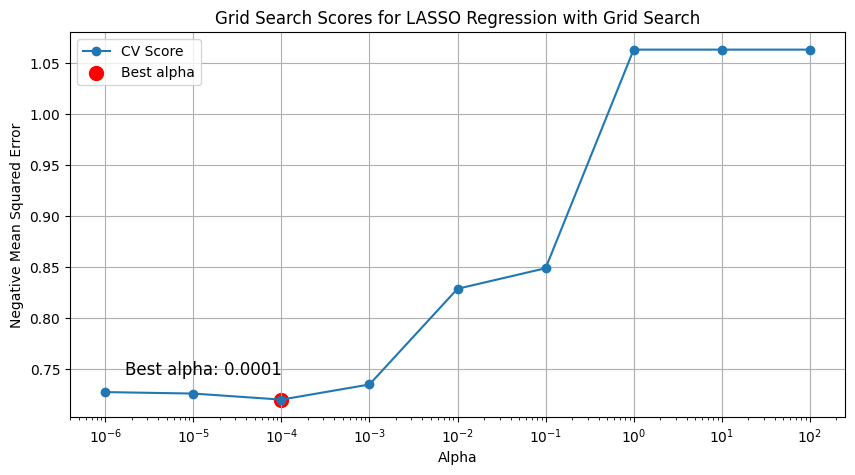

Best alpha for LASSO: {'alpha': 0.0001}


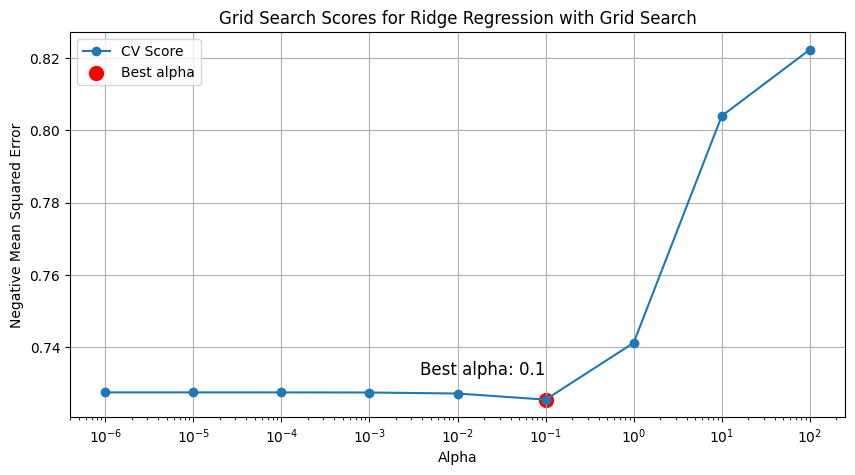

Best alpha for Ridge: {'alpha': 0.1}


In [ ]:
import warnings
from sklearn.exceptions import ConvergenceWarning
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import make_pipeline

# Ignore ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

# Load the datasets
train_data = pd.read_csv('/content/drive/MyDrive/Machine/Assignment2/train_data.csv')
validation_data = pd.read_csv('/content/drive/MyDrive/Machine/Assignment2/validation_data.csv')

# Assuming 'price' is the target variable
y_train = train_data['price']
y_val = validation_data['price']

# Prepare the features
X_train = pd.get_dummies(train_data.drop('price', axis=1))
X_val = pd.get_dummies(validation_data.drop('price', axis=1))

# Ensure both datasets have the same dummy variables
X_train, X_val = X_train.align(X_val, join='inner', axis=1)

def evaluate_model(model, X_train, y_train, X_val, y_val, model_name, plot=False):
    model.fit(X_train, y_train)
    predictions = model.predict(X_val)
    mse = mean_squared_error(y_val, predictions)
    mae = mean_absolute_error(y_val, predictions)
    r2 = r2_score(y_val, predictions)

    if plot:
        results = pd.DataFrame(model.cv_results_)
        best_alpha = model.best_params_['alpha']
        best_score = -model.best_score_

        plt.figure(figsize=(10, 5))
        plt.semilogx(results['param_alpha'].values, -results['mean_test_score'], marker='o', label='CV Score')
        plt.scatter(best_alpha, best_score, color='red', s=100, label='Best alpha')
        plt.text(best_alpha, best_score, f'Best alpha: {best_alpha}\n', fontsize=12, verticalalignment='bottom', horizontalalignment='right')

        plt.title(f"Grid Search Scores for {model_name}")
        plt.xlabel('Alpha')
        plt.ylabel('Negative Mean Squared Error')
        plt.legend()
        plt.grid(True)
        plt.show()

# Proceed with your model evaluations and grid search setups as you had them.

# Grid Search for LASSO and Ridge
parameters = {'alpha': np.logspace(-6, 2, 9)}
lasso_grid = GridSearchCV(Lasso(), parameters, cv=5, scoring='neg_mean_squared_error')
ridge_grid = GridSearchCV(Ridge(), parameters, cv=5, scoring='neg_mean_squared_error')

evaluate_model(lasso_grid, X_train, y_train, X_val, y_val, "LASSO Regression with Grid Search", plot=True)
print("Best alpha for LASSO:", lasso_grid.best_params_)

evaluate_model(ridge_grid, X_train, y_train, X_val, y_val, "Ridge Regression with Grid Search", plot=True)
print("Best alpha for Ridge:", ridge_grid.best_params_)


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, r2_score

# Load datasets
train_data = pd.read_csv('/content/drive/MyDrive/Machine/Assignment2/train_data.csv')
validation_data = pd.read_csv('/content/drive/MyDrive/Machine/Assignment2/validation_data.csv')
test_data = pd.read_csv('/content/drive/MyDrive/Machine/Assignment2/test_data.csv')

# Preprocessing: Drop unnecessary columns and align datasets
X_train = train_data.drop(['price', 'car name'], axis=1)
y_train = train_data['price']
X_val = validation_data.drop(['price', 'car name'], axis=1)
y_val = validation_data['price']
X_test = test_data.drop(['price', 'car name'], axis=1)
y_test = test_data['price']

# Align features across datasets
X_train, X_val = X_train.align(X_val, join='inner', axis=1, fill_value=0)
X_train, X_test = X_train.align(X_test, join='inner', axis=1, fill_value=0)

# Combine training and validation sets for final evaluation
X_combined = pd.concat([X_train, X_val], axis=0)
y_combined = pd.concat([y_train, y_val], axis=0)

# Initialize a list to store results
results_list = []

# Iterate over polynomial degrees and Ridge alphas
for degree in range(2, 11):  # Degrees 2 to 10
    for alpha in [1, 10, 100, 1000]:
        pipeline = make_pipeline(PolynomialFeatures(degree), StandardScaler(), Ridge(alpha=alpha))

        # Fit on combined training + validation data
        pipeline.fit(X_combined, y_combined)

        # Predict on training, validation, and test sets
        y_train_pred = pipeline.predict(X_train)
        y_val_pred = pipeline.predict(X_val)
        y_test_pred = pipeline.predict(X_test)

        # Calculate metrics
        train_mse = mean_squared_error(y_train, y_train_pred)
        val_mse = mean_squared_error(y_val, y_val_pred)
        test_mse = mean_squared_error(y_test, y_test_pred)
        test_r2 = r2_score(y_test, y_test_pred)

        # Store results in the list
        results_list.append({
            'Degree': degree,
            'Alpha': alpha,
            'Train MSE': train_mse,
            'Validation MSE': val_mse,
            'Test MSE': test_mse,
            'Test R2': test_r2
        })

# Create a DataFrame from the results
results = pd.DataFrame(results_list)

# Print all results
print(results)

# Find the best model based on the lowest Test MSE
best_model_info = results.loc[results['Test MSE'].idxmin()]
best_degree = best_model_info['Degree']
best_alpha = best_model_info['Alpha']

print("\nBest Model Configuration:")
print(f"Degree: {best_degree}, Alpha: {best_alpha}")
print(f"Test MSE: {best_model_info['Test MSE']:.4f}, Test R2: {best_model_info['Test R2']:.4f}")


    Degree  Alpha  Train MSE  Validation MSE  Test MSE   Test R2
0        2      1   0.494966        0.275958  0.702500  0.482590
1        2     10   0.496128        0.272968  0.704700  0.480970
2        2    100   0.509490        0.256492  0.727394  0.464255
3        2   1000   0.573640        0.243190  0.851221  0.373053
4        3      1   0.221695        0.191701  0.698976  0.485186
5        3     10   0.226062        0.197384  0.690645  0.491321
6        3    100   0.242410        0.207084  0.670959  0.505821
7        3   1000   0.323108        0.221265  0.709449  0.477472
8        4      1   0.123467        0.120105  1.352555  0.003808
9        4     10   0.134656        0.129451  1.123418  0.172573
10       4    100   0.161896        0.150643  0.848102  0.375351
11       4   1000   0.225156        0.188870  0.657968  0.515389
12       5      1   0.096551        0.088650  1.233572  0.091442
13       5     10   0.105121        0.101717  1.211453  0.107733
14       5    100   0.128

Best parameters for RBF Kernel Ridge: {'alpha': 1, 'gamma': 0.1}


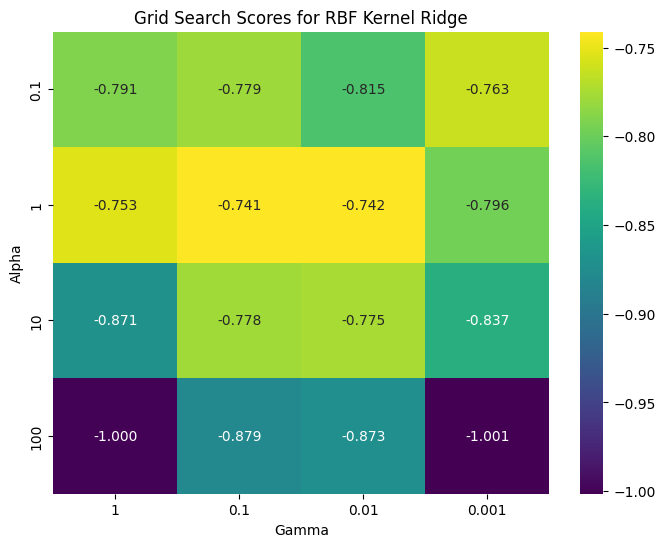

In [ ]:
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load and prepare the dataset
train_data = pd.read_csv('/content/drive/MyDrive/Machine/Assignment2/train_data.csv')
X_train = pd.get_dummies(train_data.drop(['price', 'car name'], axis=1))
y_train = train_data['price']

# Parameters for Grid Search
parameters = {'alpha': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001]}
kr_grid = GridSearchCV(KernelRidge(kernel='rbf'), parameters, cv=5, scoring='neg_mean_squared_error')

# Fit the model and find the best parameters
kr_grid.fit(X_train, y_train)
print("Best parameters for RBF Kernel Ridge:", kr_grid.best_params_)

# Retrieve the mean test scores
scores = kr_grid.cv_results_['mean_test_score']
scores = np.array(scores).reshape(len(parameters['alpha']), len(parameters['gamma']))

# Plotting
plt.figure(figsize=(8, 6))
sns.heatmap(scores, annot=True, fmt=".3f", cmap='viridis',
            xticklabels=parameters['gamma'], yticklabels=parameters['alpha'])
plt.title('Grid Search Scores for RBF Kernel Ridge')
plt.xlabel('Gamma')
plt.ylabel('Alpha')
plt.show()


---
**Chapter 5: Final Evaluation of Test Set**
---


Test Set Evaluation (Degree 4, Alpha 1000):
Test MSE: 0.6828
Test MAE: 0.2400
Test R²: 0.4971


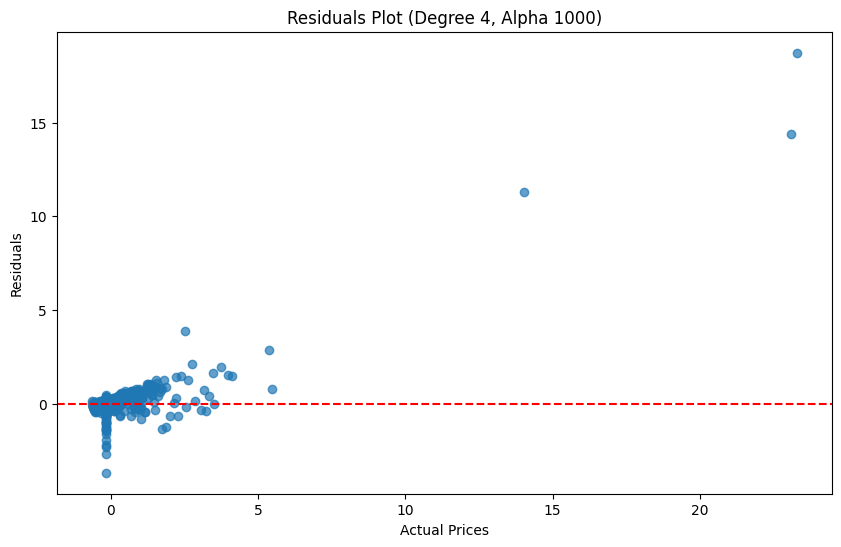

In [ ]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load test data
test_data = pd.read_csv('/content/drive/MyDrive/Machine/Assignment2/test_data.csv')

# Preprocessing: Drop unnecessary columns and align datasets
X_test = test_data.drop(['price', 'car name'], axis=1)
y_test = test_data['price']

train_data = pd.read_csv('/content/drive/MyDrive/Machine/Assignment2/train_data.csv')  # Reload train data
X_train = train_data.drop(['price', 'car name'], axis=1) # Recreate X_train as DataFrame


# Align features with training data (reusing X_train from training script)
X_train, X_test = X_train.align(X_test, join='inner', axis=1, fill_value=0)

# Train the best model (Degree 4, Alpha 1000)
best_pipeline = make_pipeline(PolynomialFeatures(4), StandardScaler(), Ridge(alpha=1000))
best_pipeline.fit(X_train, y_train)

# Predict on the test set
y_test_pred = best_pipeline.predict(X_test)

# Calculate metrics
test_mse = mean_squared_error(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("\nTest Set Evaluation (Degree 4, Alpha 1000):")
print(f"Test MSE: {test_mse:.4f}")
print(f"Test MAE: {test_mae:.4f}")
print(f"Test R²: {test_r2:.4f}")

# Calculate residuals
residuals = y_test - y_test_pred

# Plot residuals
plt.figure(figsize=(10, 6))
plt.scatter(y_test, residuals, alpha=0.7)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals Plot (Degree 4, Alpha 1000)")
plt.xlabel("Actual Prices")
plt.ylabel("Residuals")
plt.show()


---
**Chapter 6 : Regression Model for a New Target**
---


`6.1. `SVR with RBF Kernel to predict horse_power.

SVR with RBF Kernel:
Training Data - MSE: 0.47, MAE: 0.22, R^2: 0.592
Validation Data - MSE: 0.09, MAE: 0.20, R^2: 0.861
Test Data - MSE: 0.19, MAE: 0.21, R^2: 0.778





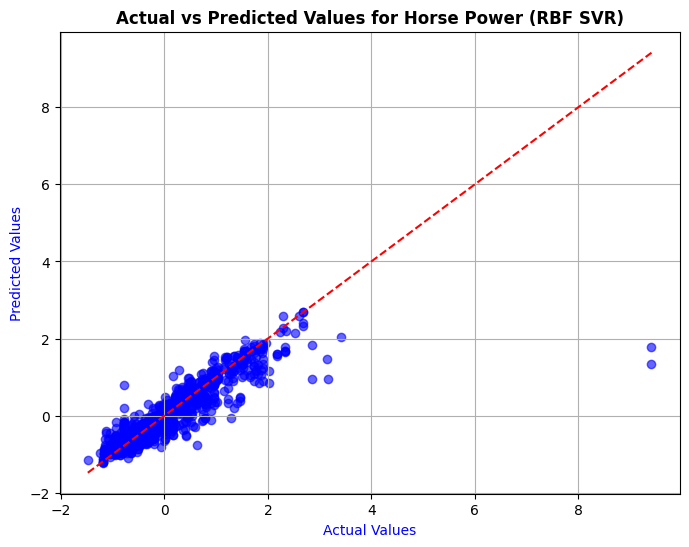

In [ ]:
import pandas as pd
import numpy as np
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Load data
train_data = pd.read_csv('/content/drive/MyDrive/Machine/Assignment2/train_data.csv')
validation_data = pd.read_csv('/content/drive/MyDrive/Machine/Assignment2/validation_data.csv')
test_data = pd.read_csv('/content/drive/MyDrive/Machine/Assignment2/test_data.csv')

# Define target variable (horse_power)
target_variable = 'horse_power'

# Remove non-numeric and unnecessary columns (except 'price' as you want to keep it)
train_data = train_data.drop(['car name'], axis=1)
validation_data = validation_data.drop(['car name'], axis=1)
test_data = test_data.drop(['car name'], axis=1)

# Define targets and features (keep 'price' as a feature)
y_train = train_data[target_variable].values
y_val = validation_data[target_variable].values
y_test = test_data[target_variable].values

X_train = train_data.drop([target_variable], axis=1)  # Do not drop 'price'
X_val = validation_data.drop([target_variable], axis=1)  # Do not drop 'price'
X_test = test_data.drop([target_variable], axis=1)  # Do not drop 'price'

# Align feature sets across training, validation, and test sets
X_train, X_val = X_train.align(X_val, join='inner', axis=1)
X_train, X_test = X_train.align(X_test, join='inner', axis=1)

# Convert to numpy arrays
X_train = X_train.values
X_val = X_val.values
X_test = X_test.values

# Initialize and train SVR with RBF kernel
rbf_svr = SVR(kernel='rbf', C=1.0, gamma='scale')
rbf_svr.fit(X_train, y_train)

# Predictions
y_train_pred = rbf_svr.predict(X_train)
y_val_pred = rbf_svr.predict(X_val)
y_test_pred = rbf_svr.predict(X_test)

# Calculate metrics for training, validation, and test data
mse_train = mean_squared_error(y_train, y_train_pred)
mae_train = mean_absolute_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)

mse_val = mean_squared_error(y_val, y_val_pred)
mae_val = mean_absolute_error(y_val, y_val_pred)
r2_val = r2_score(y_val, y_val_pred)

mse_test = mean_squared_error(y_test, y_test_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

# Print metrics
print("SVR with RBF Kernel:")
print(f"Training Data - MSE: {mse_train:.2f}, MAE: {mae_train:.2f}, R^2: {r2_train:.3f}")
print(f"Validation Data - MSE: {mse_val:.2f}, MAE: {mae_val:.2f}, R^2: {r2_val:.3f}")
print(f"Test Data - MSE: {mse_test:.2f}, MAE: {mae_test:.2f}, R^2: {r2_test:.3f}")
print("\n\n")

# Plot actual vs. predicted values for test data
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred, alpha=0.6, color='blue')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel('Actual Values', color='blue')
plt.ylabel('Predicted Values', color='blue')
plt.title('Actual vs Predicted Values for Horse Power (RBF SVR)', fontweight='bold', color='black')
plt.grid()
plt.show()


---
**Chapter 7 : Visualizations**
---


`9.1.` Visualizations to support findings

*   Feature Importance Visualization
*   Error Distribution Visualization
*   Model Predictions vs. Actual Values Visualization
*   Residuals vs. Fitted Values





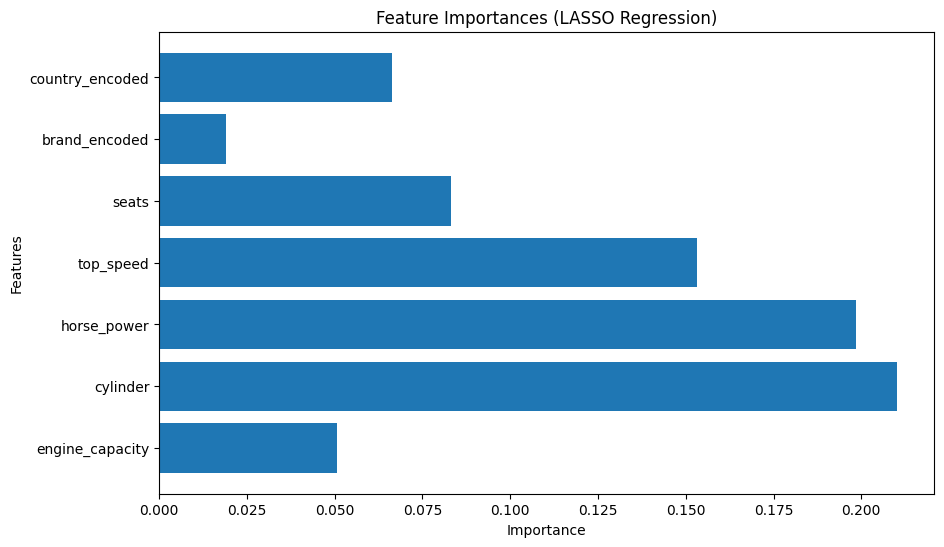

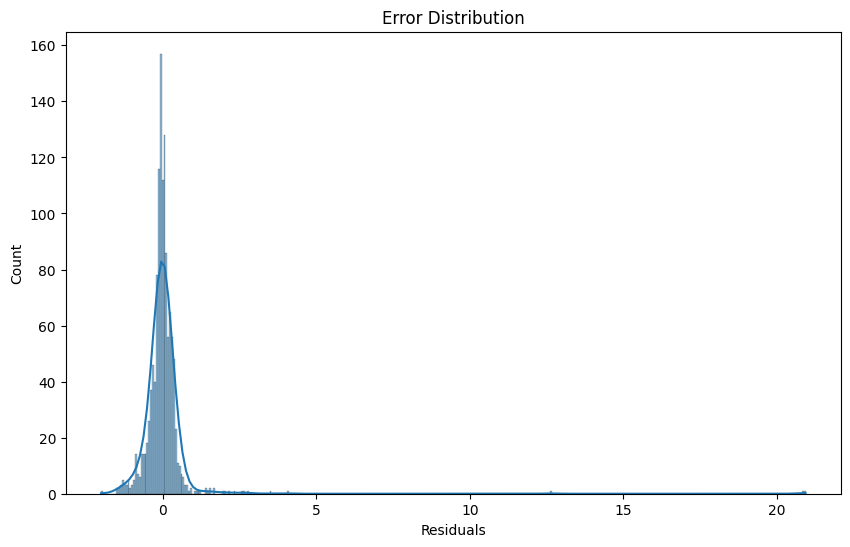

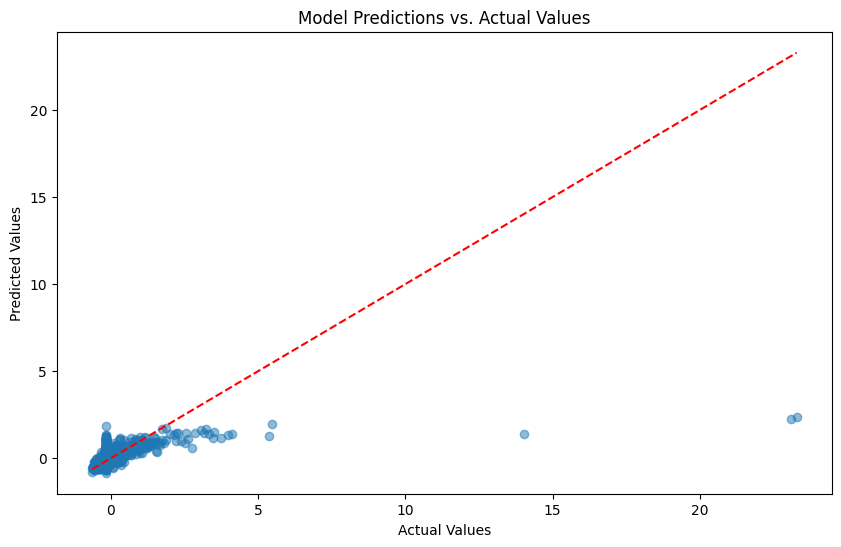

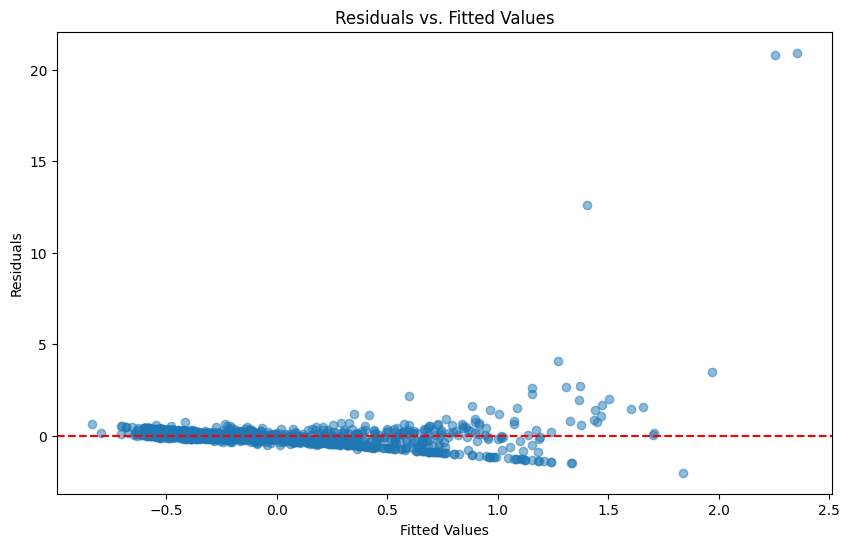

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import Lasso

# Load the datasets
train_data = pd.read_csv('/content/drive/MyDrive/Machine/Assignment2/train_data.csv')
validation_data = pd.read_csv('/content/drive/MyDrive/Machine/Assignment2/validation_data.csv')
test_data = pd.read_csv('/content/drive/MyDrive/Machine/Assignment2/test_data.csv')

# Drop the 'car name' column
train_data = train_data.drop('car name', axis=1)
validation_data = validation_data.drop('car name', axis=1)
test_data = test_data.drop('car name', axis=1)

# Prepare features and target variable
X_train = train_data.drop('price', axis=1)
y_train = train_data['price']
X_validation = validation_data.drop('price', axis=1)
y_validation = validation_data['price']
X_test = test_data.drop('price', axis=1)
y_test = test_data['price']

# Combine training and validation sets
X_train_full = pd.concat([X_train, X_validation])
y_train_full = pd.concat([y_train, y_validation])

# Train the best LASSO model
best_lasso = Lasso(alpha=0.001)
best_lasso.fit(X_train_full, y_train_full)

# Predict on the test set
y_pred = best_lasso.predict(X_test)

# Calculate residuals
residuals = y_test - y_pred

# Feature Importance Visualization
feature_importances = np.abs(best_lasso.coef_)
features = X_train.columns

plt.figure(figsize=(10, 6))
plt.barh(features, feature_importances)
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importances (LASSO Regression)')
plt.show()

# Error Distribution Visualization
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.xlabel('Residuals')
plt.title('Error Distribution')
plt.show()

# Model Predictions vs. Actual Values Visualization
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Model Predictions vs. Actual Values')
plt.show()

# Residuals vs. Fitted Values
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted Values')
plt.show()


`9.2. `Performance Comparison Across Models

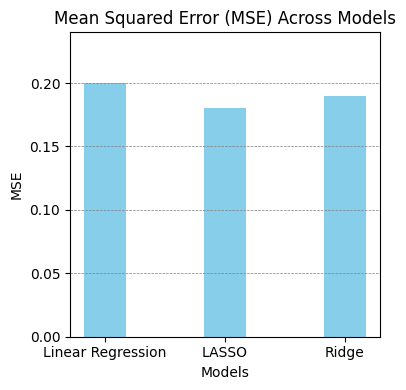

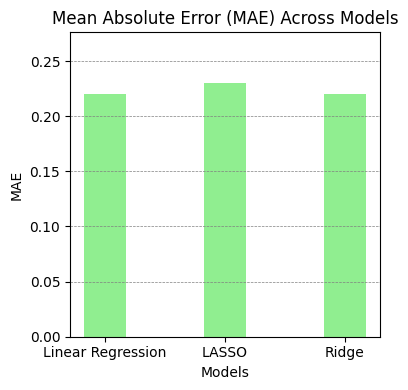

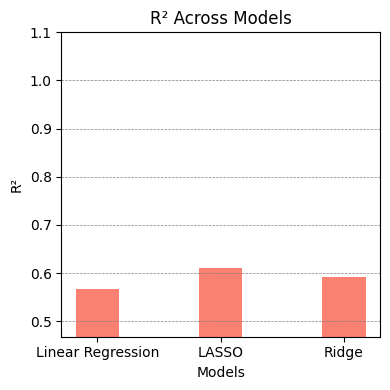

In [ ]:
import matplotlib.pyplot as plt

def plot_individual_metrics_compact(models, mse_values, mae_values, r2_values):
    bar_width = 0.35  # Adjusted width for compactness
    x_positions = range(len(models))  # Define positions for bars

    # Plot MSE
    plt.figure(figsize=(4, 4))  # Smaller figure size for compactness
    plt.bar(x_positions, mse_values, color='skyblue', width=bar_width)
    plt.ylim(0, max(mse_values) * 1.2)  # Adjust y-scale for clarity
    plt.xticks(x_positions, models)  # Reduce the margin between bars
    plt.title('Mean Squared Error (MSE) Across Models')
    plt.xlabel('Models')
    plt.ylabel('MSE')
    plt.grid(axis='y', linestyle='--', linewidth=0.5, color='gray')
    plt.tight_layout()
    plt.show()

    # Plot MAE
    plt.figure(figsize=(4, 4))
    plt.bar(x_positions, mae_values, color='lightgreen', width=bar_width)
    plt.ylim(0, max(mae_values) * 1.2)  # Adjust y-scale for clarity
    plt.xticks(x_positions, models)  # Reduce the margin between bars
    plt.title('Mean Absolute Error (MAE) Across Models')
    plt.xlabel('Models')
    plt.ylabel('MAE')
    plt.grid(axis='y', linestyle='--', linewidth=0.5, color='gray')
    plt.tight_layout()
    plt.show()

    # Plot R²
    plt.figure(figsize=(4, 4))
    plt.bar(x_positions, r2_values, color='salmon', width=bar_width)
    plt.ylim(min(r2_values) - 0.1, 1.1)  # Adjust y-scale to include R² range
    plt.xticks(x_positions, models)  # Reduce the margin between bars
    plt.title('R² Across Models')
    plt.xlabel('Models')
    plt.ylabel('R²')
    plt.grid(axis='y', linestyle='--', linewidth=0.5, color='gray')
    plt.tight_layout()
    plt.show()

# Call the function with example data
models = ["Linear Regression", "LASSO", "Ridge"]
mse_values = [0.20, 0.18, 0.19]
mae_values = [0.22, 0.23, 0.22]
r2_values = [0.568, 0.611, 0.593]

plot_individual_metrics_compact(models, mse_values, mae_values, r2_values)
